# Visualisation of the borsuk envelope

### Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os.path
import http.client
import json
import urllib.request
import requests
from urllib import error
import configparser 
import time
import datetime
import re
from scipy import stats

### Accessing the token
Loading the data for the channel

In [2]:
config = configparser.ConfigParser()
config.read("config.txt")
http_client = config.get("configuration","http_client")
conn = http.client.HTTPConnection(http_client)
headers = {'Content-type': 'application/json'}
Username = config.get("configuration","user")
Password = config.get("configuration","password")
body = { 'Username': Username, 'Password': Password}
conn.request("POST","/auth/authenticate", json.dumps(body),headers)
response = conn.getresponse()
x = response.read().decode()
token = json.loads(x)['token']

### Loading the data set

In [3]:
url_rain = config.get("configuration", "url_rain") + token
url_flow = config.get("configuration", "url_flow") + token
df_rain = pd.read_csv(url_rain, parse_dates=['time'])
df_flow = pd.read_csv(url_flow, parse_dates=['time'])

### Filling missing dates in datasets

In [4]:
df_rain = df_rain.set_index('time')
df_rain = df_rain.resample('300S').asfreq()
df_flow = df_flow.set_index('time')
df_flow = df_flow.resample('900S').asfreq()

In [5]:
df_rain = df_rain.reset_index()

In [6]:
df_flow = df_flow.reset_index()

In [7]:
df_rain = df_rain.fillna(-1)
df_flow = df_flow.fillna(-1)

### Taking the fragment of the data to the model

In [8]:
split_rain = df_rain[(df_rain['time'] > '2012-09-15 00:07:25')]
#split_rain = split_rain[(split_rain['time'] < '2016-4-9 00:00:00')]
split_flow = df_flow[(df_flow['time'] > '2011-07-12 12:00:00')]
#split_flow = split_flow[(split_flow['time'] < '2016-4-9 00:00:00')]

In [9]:
split_flow.head()

,time,value
0,2011-07-12 12:15:00,2.267409
1,2011-07-12 12:30:00,2.314310
2,2011-07-12 12:45:00,2.259863
3,2011-07-12 13:00:00,2.153435
4,2011-07-12 13:15:00,2.085203


### Creating json variable

In [10]:
envelope =  {
	"rainfall" : {
		"start-date" : "2012-09-15 07:30:00",
		"resolution" : "PT5M",
		"values" : list(split_rain['value'])
	},
	"flow" : {
		"start-date" : "2011-07-12 12:15:00",
		"resolution" : "PT15M",
		"values" : list(split_flow['value'])
	},
	"stormIntensityWindow" : "PT6H",
	"flowIntensityWindow" : "PT1H",
	"dryDayWindow" : "P2D",
	"minSessionWindow" : "PT12H",
	"maxSessionWindow" : "PT12H",
    "flowBoundary" : 3
}

### POST to borsuk-envelope
{"type":"envelope-v0", "id": "model-id"}

In [11]:
env_url = config.get("configuration", "env_url")
body={"type":"envelope-v0","id": "env_test"}
response = requests.post(env_url, json=body)
print(response.status_code)
print(response.content) 

409
b'Error: Model with this id already exist.'


### GET to borsuk-envelope env-test

In [12]:
env_model = config.get("configuration", "env_model")
r = requests.get(env_model)
last_build = json.loads(r.content)['build']
print(last_build)

6


### POST to borsuk-envelope json
The change of status informs that the post is finished

In [13]:
env_fit = config.get("configuration", "env_fit")
response = requests.post(env_fit, json=envelope)
print(response.status_code)
print(response.content)

200
b'OK'


In [15]:
print("Primary status: ",last_build)
start_time = time.time()

while True:
    r = requests.get(env_model)
    new_build = json.loads(r.content)['build']
    if new_build > last_build:
        print("Status after post: ",new_build)
        break

print("--- %s seconds ---" % (time.time() - start_time))

Primary status:  6
Status after post:  7
--- 0.7973537445068359 seconds ---


### GET to borsuk-envelope to list envelopes

In [16]:
env_list = config.get("configuration", "env_id")
r = requests.get(env_list)
b = json.loads(r.content)

In [17]:
a = json.loads(r.content)['envelope'][0]['id']

In [18]:
env_id = config.get("configuration", "env_id")
envelope_id = env_id + '/' + a

### GET to borsuk-envelope for specific id

In [19]:
r = requests.get(envelope_id)
envelope = json.loads(r.content)
envelope

{'intercept': 3.8492303087699113,
 'storms': [4.129999918863177,
  2.8499999530613422,
  2.46999997459352,
  2.149999938905239,
  2.1199999526143074,
  2.0899999421089888,
  2.029999939724803,
  1.869999960064888,
  1.7099999580532312,
  1.6899999473243952,
  1.649999987334013,
  1.6199999433010817,
  1.5999999549239874,
  1.5899999924004078,
  1.539999969303608,
  1.5199999567121267,
  1.4599999953061342,
  1.4399999994784594,
  1.369999984279275,
  1.329999977722764,
  1.3199999704957008,
  1.2899999842047691,
  1.2599999904632568,
  1.2399999648332596,
  1.2399999648332596,
  1.2199999708682299,
  1.1899999734014273,
  1.1499999854713678,
  1.139999970793724,
  1.0799999684095383,
  1.0700000133365393,
  1.0699999779462814,
  1.0599999837577343,
  1.0599999763071537,
  1.0099999830126762,
  0.9899999760091305,
  0.8599999807775021,
  0.7099999841302633,
  0.639999981969595,
  0.6199999954551458,
  0.5299999918788671,
  0.3499999940395355,
  0.2799999937415123,
  0.11999999918043613,

### Creating variables from json envelope 

In [20]:
intercept = envelope['intercept']
storms = envelope['storms']
dates = envelope['dates']
rsquare = envelope['rsquare']
flow = envelope['flow']
slope = envelope['slope']

### Calculate regression

In [21]:
slope, intercept, r_value, p_value, std_err = stats.linregress(storms, flow)
xs = [0] + storms + [70]
ys = [slope*x+intercept for x in xs]
max_res = max([flow[n] - (slope*storms[n]+intercept) for n in range(len(storms))])
ys2 = [y + max_res for y in ys]

### Plot borsuk envelope

Text(0,0.5,'Peak 1hr RDII (l/s)')

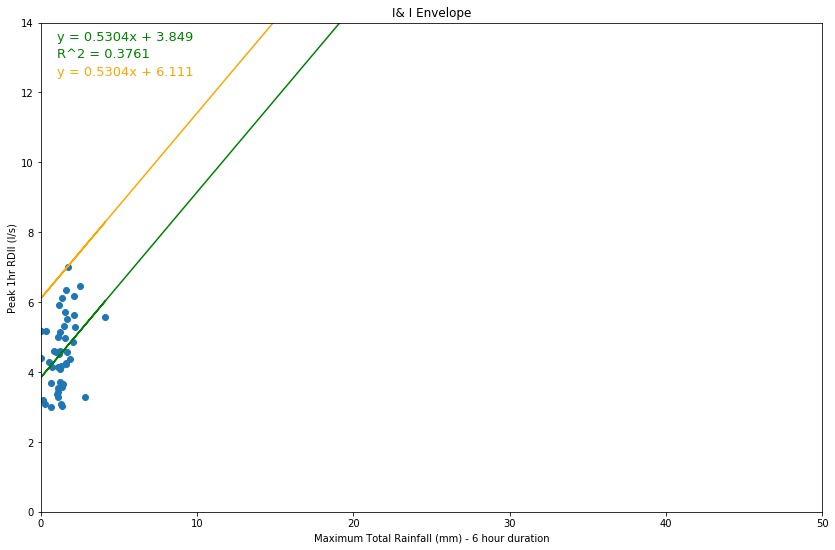

In [22]:
rcParams['figure.figsize'] = 14, 9
plt.xlim([0,50])
plt.ylim([0,14])
plt.plot(xs, ys, 'g')
plt.plot(xs, ys2, 'orange')
plt.scatter(storms, flow)

plt.text(1, 13.5, 'y = {:.4}x + {:.4}'.format(slope, intercept), color='green', fontsize=13)
plt.text(1, 13, 'R^2 = {:.4}'.format(r_value), color='green', fontsize=13)
plt.text(1, 12.5, 'y = {:.4}x + {:.4}'.format(slope, intercept+max_res), color='orange', fontsize=13)

plt.title('I& I Envelope')
plt.xlabel('Maximum Total Rainfall (mm) - 6 hour duration')
plt.ylabel('Peak 1hr RDII (l/s)')

# Comparing results with flowworks

### GET to flowworks data

In [23]:
env_flowworks = config.get("configuration", "env_flowworks")
r = requests.get(env_flowworks)
fworks = json.loads(r.content)
fworks

{'intercept': 4.251800151242644,
 'storms': [1.6799999848008156,
  1.649999987334013,
  1.4599999953061342,
  1.2899999842047691,
  1.2599999904632568,
  1.2599999867379665,
  1.1499999854713678,
  1.0700000133365393],
 'flows': [3.29435071349144,
  4.572286754846573,
  5.307582199573517,
  3.0786569118499756,
  4.161497890949249,
  5.565868228673935,
  4.510969281196594,
  3.550989270210266],
 'dates': [{'from': '2014-09-07T14:15:00Z', 'to': '2014-09-08T03:00:00Z'},
  {'from': '2015-08-18T11:00:00Z', 'to': '2015-08-18T18:15:00Z'},
  {'from': '2015-08-22T18:00:00Z', 'to': '2015-08-23T10:00:00Z'},
  {'from': '2014-11-16T20:30:00Z', 'to': '2014-11-17T09:15:00Z'},
  {'from': '2014-11-23T02:45:00Z', 'to': '2014-11-23T18:30:00Z'},
  {'from': '2013-05-19T01:30:00Z', 'to': '2013-05-19T13:00:00Z'},
  {'from': '2015-08-17T07:45:00Z', 'to': '2015-08-17T19:30:00Z'},
  {'from': '2015-05-31T13:15:00Z', 'to': '2015-05-31T22:00:00Z'}],
 'rsquare': -0.16666620332085547,
 'slope': 0.0025693198739629407

### Creating variables from flowworks json

In [24]:
f_intercept = fworks['intercept']
f_storms = fworks['storms']
f_dates = fworks['dates']
f_rsquare = fworks['rsquare']
f_flow = fworks['flows']
f_slope = fworks['slope']

In [25]:
#borsuk
rsquare

0.12193557105041275

In [26]:
#flowworks
f_rsquare

-0.16666620332085547

### Calculate regression

In [27]:
f_slope, f_intercept, f_r_value, f_p_value, f_std_err = stats.linregress(f_storms, f_flow)
f_xs = [0] + f_storms + [70]
f_ys = [f_slope*x+f_intercept for x in f_xs]
f_max_res = max([f_flow[n] - (f_slope*f_storms[n]+f_intercept) for n in range(len(f_storms))])
f_ys2 = [y + f_max_res for y in f_ys]

### Plot flowworks envelope

Text(0,0.5,'Peak 1hr RDII (l/s)')

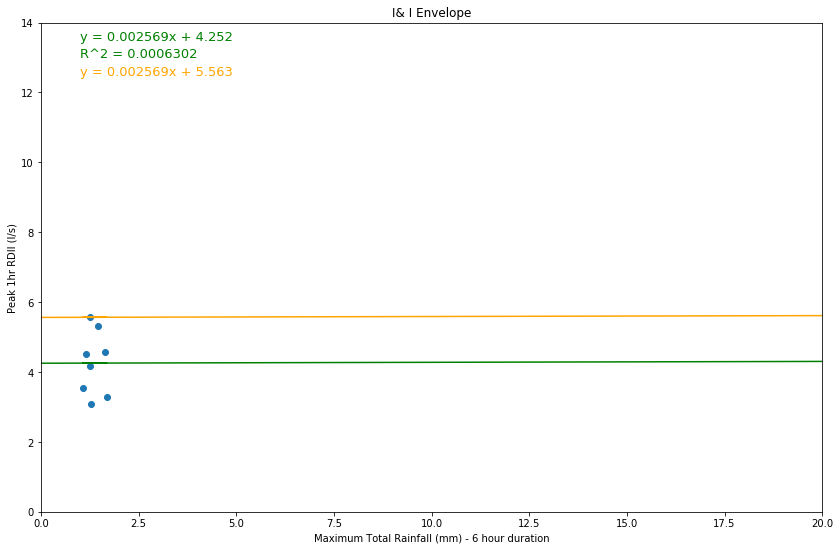

In [28]:
rcParams['figure.figsize'] = 14, 9
plt.xlim([0,20])
plt.ylim([0,14])
plt.plot(f_xs, f_ys, 'g')
plt.plot(f_xs, f_ys2, 'orange')
plt.scatter(f_storms, f_flow)

plt.text(1, 13.5, 'y = {:.4}x + {:.4}'.format(f_slope, f_intercept), color='green', fontsize=13)
plt.text(1, 13, 'R^2 = {:.4}'.format(f_r_value), color='green', fontsize=13)
plt.text(1, 12.5, 'y = {:.4}x + {:.4}'.format(f_slope, f_intercept+f_max_res), color='orange', fontsize=13)

plt.title('I& I Envelope')
plt.xlabel('Maximum Total Rainfall (mm) - 6 hour duration')
plt.ylabel('Peak 1hr RDII (l/s)')